<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Compare_networks_on_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare networks on ImageNet

## Imports


In [1]:
!pip install scipy==1.2.0
!pip install wget
!pip install -q git+https://github.com/albermax/innvestigate
!git clone https://github.com/infomon/understanding_cnn
  
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_imagenet.py"):
  shutil.move("/content/understanding_cnn/utils/utils_imagenet.py", "/content")
if not os.path.isdir("models"):
  shutil.move("/content/understanding_cnn/models", "/content")
if not os.path.isdir("images"):
  shutil.move("/content/understanding_cnn/data/images", "/content")
if not os.path.isfile("data_loader.py"):
  shutil.move("/content/understanding_cnn/data/data_loader.py", "/content")
  
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 309 (delta 39), reused 14 (delta 5), pack-reused 221
Receiving objects: 100% (309/309), 37.01 MiB | 42.20 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

import models.model_loader as model_loader
import data_loader

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
imgnetutils = imp.load_source("utils_imagenet", "utils_imagenet.py")

# We create many graphs, let's not run out of memory.
if keras.backend.backend() == "tensorflow":
    config = keras.backend.tf.ConfigProto()
    config.gpu_options.allow_growth = True
    keras.backend.set_session(keras.backend.tf.Session(config=config))

Using TensorFlow backend.
W0502 09:02:19.636173 140358470088576 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## Models, data and analyzers

In [0]:
# Choose a list of models
netnames = [
    # NAME                  MODEL LOADER
    #["AlexNet",             model_loader.AlexNet],
    ["VGG19",               model_loader.VGG19],
    ["Resnet_v1_101",       model_loader.Resnet_v1_101],
    ["Inception_v3",        model_loader.Inception_v3],
    ["Inception_Resnet_v2", model_loader.Inception_Resnet_v2]
]          
n_nets = len(netnames)

In [0]:
def prepare_model_data_and_analyzers(loader):
    # Load the model definition.
    model = loader(include_top=True, weights='imagenet')

    # Get some example test set images.
    data = data_loader.load_from_folder("images",model.get_image_size())

    
    images = [] 
    label_to_class_name = []
    for img,label in data:
      images.append(img)
      label_to_class_name.append(label)
      
    
    patterns = model.get_patterns()
    input_range = (-1,1)

    noise_scale = (input_range[1]-input_range[0]) * 0.1

    # Methods we use and some properties.
    methods = [
        # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
        # Show input.
        ("input",                 {"allow_lambda_layers":True},                       imgnetutils.image,         "Input"), #0

        # Function
        ("gradient",              {"postprocess": "abs", "allow_lambda_layers":True},   imgnetutils.graymap,       "Gradient"), #1
        ("smoothgrad",            {"augment_by_n": 16,
                                   "noise_scale": noise_scale,
                                   "postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"), #2

        # Signal
        ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"), #3
        ("guided_backprop",       {"allow_lambda_layers":True},                       imgnetutils.bk_proj,       "Guided Backprop",), #4
        ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"), #5

        # Interaction
        ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"), #6
        ("deep_taylor.bounded",   {"low": input_range[0],
                                   "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"), #7
        ("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"), #8
        ("integrated_gradients",  {"reference_inputs": input_range[0],
                                   "steps": 16},            imgnetutils.heatmap,       "Integrated Gradients"), #9
        ("lrp.epsilon",           {"epsilon": 1, "allow_lambda_layers":True},           imgnetutils.heatmap,        "LRP-Epsilon"), #10
        ("lrp.epsilon_IB",           {"epsilon": 1, "allow_lambda_layers":True},           imgnetutils.heatmap,        "LRP-Epsilon IB"), #11
        ("lrp.alpha_1_beta_0",           {"allow_lambda_layers":True},           imgnetutils.heatmap,        "LRP-Alpha1-Beta0"), #12
        ("lrp.alpha_1_beta_0_IB",           {"allow_lambda_layers":True},           imgnetutils.heatmap,        "LRP-Alpha1-Beta0 IB"), #13
        ("lrp.sequential_preset_a_flat",{"epsilon": 1, "allow_lambda_layers":True},     imgnetutils.heatmap,       "LRP-PresetAFlat"), #14 
        ("lrp.sequential_preset_b_flat",{"epsilon": 1, "allow_lambda_layers":True},     imgnetutils.heatmap,       "LRP-PresetBFlat"), #15
    ]
    
    # Select methods of your choice
    selected_methods_indices = [0,1,4,7,9,13,14,15]
    selected_methods = [methods[i] for i in selected_methods_indices]
    print('Using method(s) "{}".'.format([method[0] for method in selected_methods]))
    
    # Create model without trailing softmax
    model_wo_softmax = model.get_model()

    # Create analyzers.
    analyzers = []
    for method in selected_methods:
        try:
            analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                    model_wo_softmax, # model without softmax output
                                                    **method[1])      # optional analysis parameters
        except innvestigate.NotAnalyzeableModelException as e:
            analyzer = None
            print(method[3]+" cannot be used!")
            print(str(e))
        analyzers.append(analyzer)
        
    return (images, label_to_class_name,
            selected_methods, model, model_wo_softmax, analyzers)

## Analysis

Now we analyze each image with the different networks and different analyzers:

In [6]:
import matplotlib.pyplot as plt

analyses = {}
texts = {}
    
for (netname,loader) in netnames:
    print("Creating analyses for network {}.".format(netname))
    tmp = prepare_model_data_and_analyzers(loader)
    (images, label_to_class_name,
     methods, model, model_wo_softmax, analyzers) = tmp
    
    analysis = np.zeros([len(images), len(analyzers)]+list(model.get_image_size())+[3])
    text = []
    
    channels_first = keras.backend.image_data_format() == "channels_first"
    color_conversion = "BGRtoRGB" if model.get_color_coding() == "BGR" else None

    for i, x in enumerate(images):
        # Add batch axis.
        # Add batch axis.
        x = x[None, :, :, :]
        x_pp = model.preprocess_input(x)

        # Predict final activations, probabilites, and label.
        presm = model.predict_wo_softmax(x_pp)[0]
        prob = model.predict_with_softmax(x_pp)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[i],    # ground truth label
                     "%.2f" % presm.max(),             # pre-softmax logits
                     "%.2f" % prob.max(),              # probabilistic softmax output  
                     "%s" % model.decode_predictions(prob[None,...], top=1)[0][0][1] # predicted label
                    ))

        for aidx, analyzer in enumerate(analyzers):
            print(methods[aidx][0]+" for image with label "+label_to_class_name[i])
            if methods[aidx][0] == "input":
                # Do not analyze, but keep not preprocessed input.
                a = x/255
            elif analyzer:
                # Analyze.
                a = analyzer.analyze(x_pp)

                # Apply common postprocessing, e.g., re-ordering the channels for plotting.
                a = imgnetutils.postprocess(a, color_conversion, channels_first)
                # Apply analysis postprocessing, e.g., creating a heatmap.
                a = methods[aidx][2](a)
            else:
                a = np.zeros_like(x)
            # Store the analysis.
            analysis[i, aidx] = a[0]

        analyses[netname] = analysis
        texts[netname] = text

Creating analyses for network VGG19.
Instructions for updating:
Colocations handled automatically by placer.


W0502 09:02:21.457701 140358470088576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Using method(s) "['input', 'gradient', 'guided_backprop', 'deep_taylor.bounded', 'integrated_gradients', 'lrp.alpha_1_beta_0_IB', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat']".
input for image with label tabby
gradient for image with label tabby
Instructions for updating:
Use tf.cast instead.


W0502 09:02:35.215647 140358470088576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0502 09:02:35.237643 140358470088576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


guided_backprop for image with label tabby
deep_taylor.bounded for image with label tabby
integrated_gradients for image with label tabby
lrp.alpha_1_beta_0_IB for image with label tabby
lrp.sequential_preset_a_flat for image with label tabby
lrp.sequential_preset_b_flat for image with label tabby
input for image with label airliner
gradient for image with label airliner
guided_backprop for image with label airliner
deep_taylor.bounded for image with label airliner
integrated_gradients for image with label airliner
lrp.alpha_1_beta_0_IB for image with label airliner
lrp.sequential_preset_a_flat for image with label airliner
lrp.sequential_preset_b_flat for image with label airliner
input for image with label baseball
gradient for image with label baseball
guided_backprop for image with label baseball
deep_taylor.bounded for image with label baseball
integrated_gradients for image with label baseball
lrp.alpha_1_beta_0_IB for image with label baseball
lrp.sequential_preset_a_flat for im

Next, we visualize the analysis results:

Image nr. 0, true label: tabby


<Figure size 432x288 with 0 Axes>

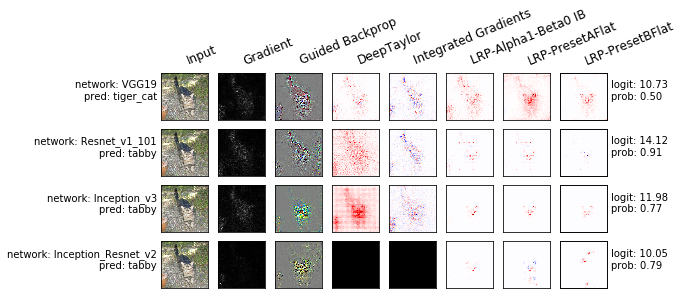

Image nr. 1, true label: airliner


<Figure size 432x288 with 0 Axes>

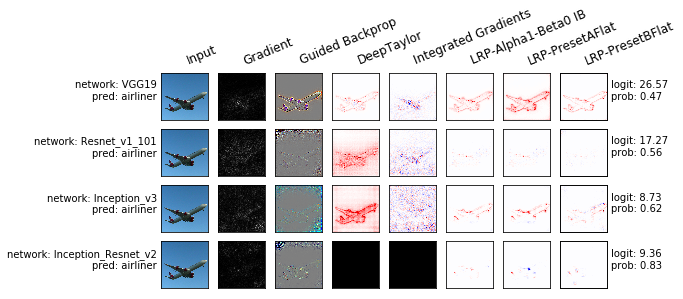

Image nr. 2, true label: baseball


<Figure size 432x288 with 0 Axes>

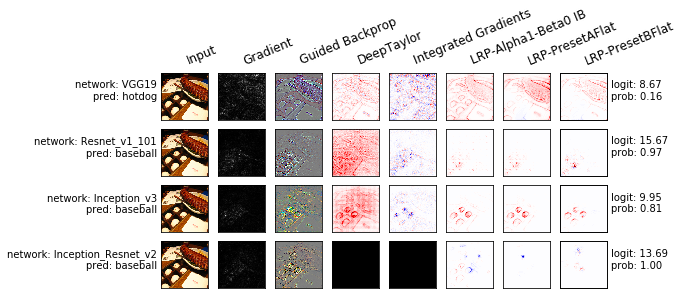

Image nr. 3, true label: leopard


<Figure size 432x288 with 0 Axes>

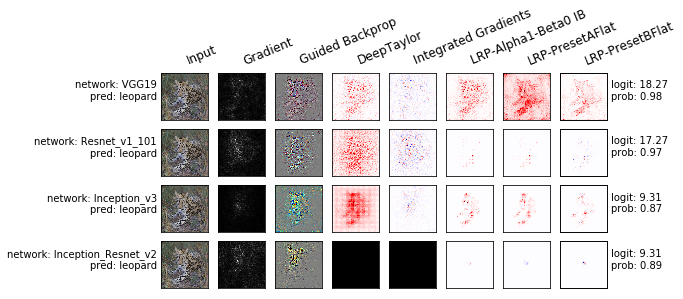

Image nr. 4, true label: Siberian_husky


<Figure size 432x288 with 0 Axes>

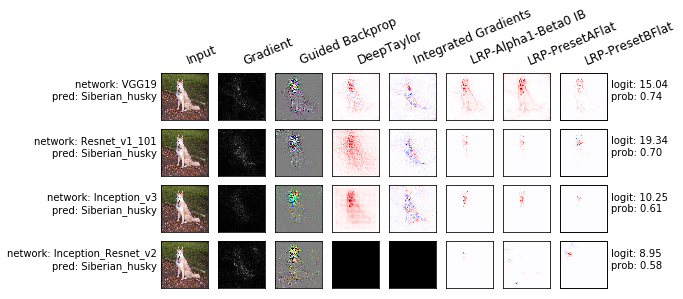

Image nr. 5, true label: bullet_train


<Figure size 432x288 with 0 Axes>

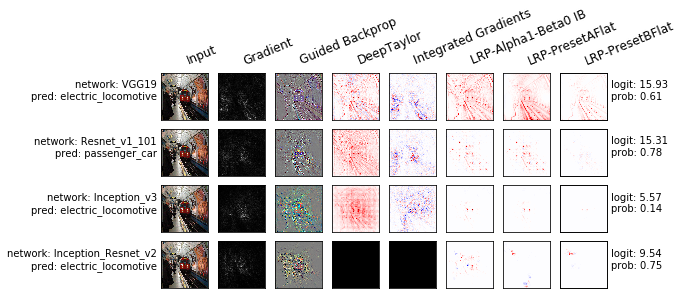

Image nr. 6, true label: partridge


<Figure size 432x288 with 0 Axes>

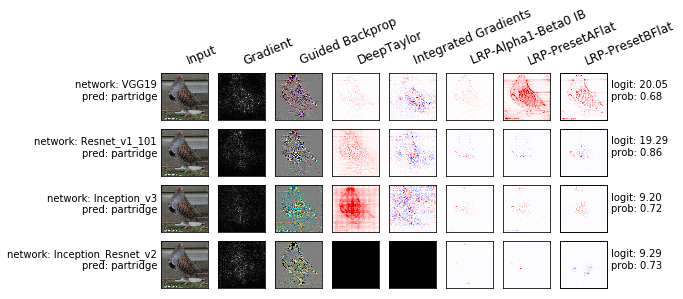

Image nr. 7, true label: African_elephant


<Figure size 432x288 with 0 Axes>

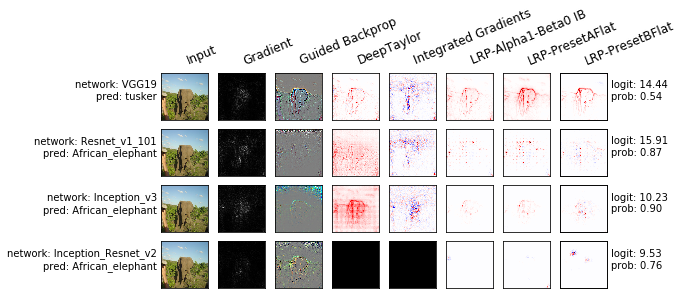

Image nr. 8, true label: sorrel


<Figure size 432x288 with 0 Axes>

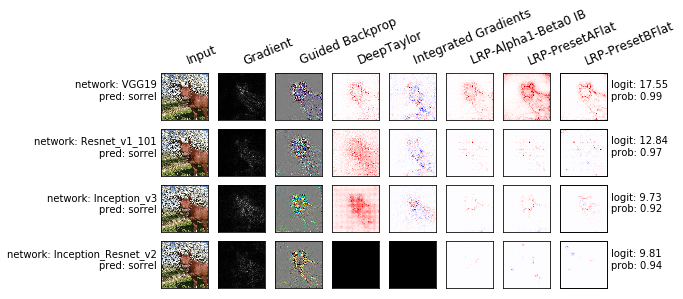

Image nr. 9, true label: accordion


<Figure size 432x288 with 0 Axes>

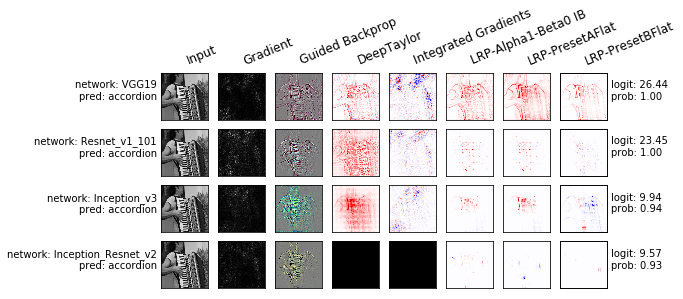

Image nr. 10, true label: Tibetan_mastiff


<Figure size 432x288 with 0 Axes>

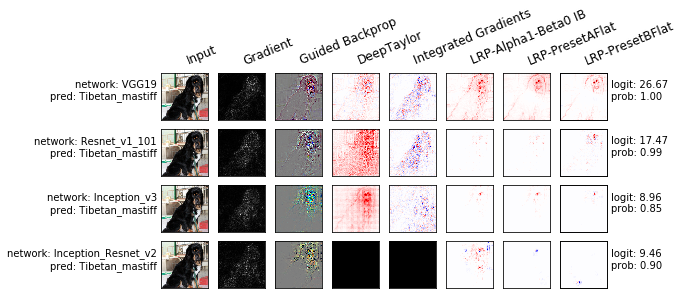

In [7]:
n_images = analyses[netnames[0][0]].shape[0]

# Prepare common labels
col_labels = [''.join(method[3]) for method in methods]

for image_index in range(n_images):
    grid = []
    row_labels_left = []
    row_labels_right = []
    
    for netname,_ in netnames:
        analysis, text = analyses[netname], texts[netname]
        # Prepare the grid as rectengular list
        grid.append([analysis[image_index, j] for j in range(analysis.shape[1])])
        # Prepare the labels
        label, presm, prob, pred = zip(*text)
        label = label[image_index]
        row_labels_left.append(('network: {}'.format(netname),'pred: {}'.format(pred[image_index])))
        row_labels_right.append(('logit: {}'.format(presm[image_index]),'prob: {}'.format(prob[image_index])))

    # Plot the analysis.
    print("Image nr. {}, true label: {}".format(image_index, label))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                           file_name=os.environ.get("plot_file_name", None))

This figures show the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).